In [1]:
pwd

'/data2/mito_lineage/Analysis/peaks_expression/jan21_2021'

In [2]:
config_f = "config.yaml"

In [3]:
from src.utils.parse_config import read_config_file
from os.path import join, dirname
import pandas as pd
from glob import glob
config = read_config_file(config_f)
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
config

import mplh.cluster_help as ch


%load_ext autoreload
%autoreload 2

fig_utils from mplh
here


### Load:
1. Raw cells barcode w qc info
2. filtered cells barcode list
3. Peak-by-cell sparse matrix
4. Peak gene annotations 
5. Graph clustering filtered cells cluster label
6. TF-by-cell sparse count matrix
7. TF labels

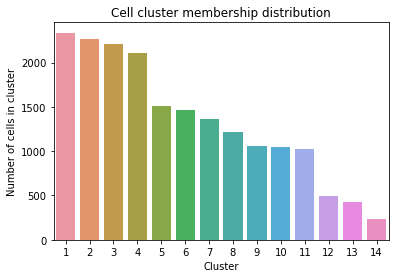

In [4]:
#curr_in = join(config["indir"], config['samples'][0], 'outs')

curr_in = join(config["indir"], "reanalysis_aggr", "outs")
samples = pd.read_csv(join(config["indir"], "barcodes_conditionInfo.csv"), header=None)

### Create 1-based cell barcode index 

cells = pd.read_csv(join(curr_in,"singlecell.csv"))
cells

good_cells = cells[~(cells["cell_id"]=="None")].copy()
good_cells["ID"] = np.arange(1,len(good_cells)+1)
good_cells

cell_inds = pd.read_csv(join(curr_in, "filtered_peak_bc_matrix","barcodes.tsv"),header=None)
cell_inds

## Load peak annotations

peak_annotations = pd.read_csv(join(curr_in,'peak_annotation.tsv'),sep='\t')
peak_annotations["gene"] = peak_annotations["gene"].str.upper()
peak_annotations["Peak"]= peak_annotations.index+1
# peak_annotations


### Load clusters

cluster_f = glob(join(curr_in,'analysis',"clustering", "graphclust","clusters.csv"))
clusters_df = pd.read_csv(cluster_f[0])
#clusters_df

%matplotlib inline
sns.countplot(clusters_df["Cluster"])
plt.title("Cell cluster membership distribution")
plt.ylabel("Number of cells in cluster")
plt.xlabel("Cluster")
## Load peaks matrix

filename = join(curr_in,'filtered_peak_bc_matrix/matrix.mtx')
peaks_sparse_mtx = pd.read_csv(filename,sep=' ',skiprows=2, header=None).iloc[1:].reset_index(drop=True)
peaks_sparse_mtx.columns = ["Peak", "Cell", "Count"]



#peaks_sparse_mtx

## Look at marker genes from Lin et al

In [5]:
immune_markers ={"cKit":"KIT", 
                 "Sca1": "LY6E", #"Ly6a",  #?? LY6K LY6E LY6H
                 "CD11c": "ITGAX",
                 "CD150": "SLAMF1", 
                 "CD34": "CD34", 
                 "CD16/32":"FCGR3A", 
                 "CD45.1": "PTPRC",
                 "CD45.2":"PTPRC", 
                 "CD48": "SLAMF2", # Other SLAMFs
                 "IL7Ra":"IL7R", 
                 "CD11b":"ITGAM"}
immune_genes = list(immune_markers.values())
immune_genes

['KIT',
 'LY6E',
 'ITGAX',
 'SLAMF1',
 'CD34',
 'FCGR3A',
 'PTPRC',
 'PTPRC',
 'SLAMF2',
 'IL7R',
 'ITGAM']

In [6]:
samples = samples.drop(0,axis=1).rename({1:"Condition"}, axis=1)
samples=pd.concat((samples,clusters_df), axis=1)
samples.index=samples.index+1
samples.head()

,Condition,Barcode,Cluster
1,Flt3l,AAACGAAAGAGCTCCC-1,4
2,Ctrl,AAACGAAAGAGGTCCA-2,5
3,Flt3l,AAACGAAAGCGATACG-1,1
4,Ctrl,AAACGAAAGCGATACG-2,6
5,Flt3l,AAACGAAAGGCTTCGC-1,5


## Filter for the immune genes 
Uses peak_annotations

In [7]:
imm_anno = peak_annotations[peak_annotations["gene"].isin(immune_genes)].set_index("Peak", drop=True)
imm_anno.head()

,peak,gene,distance,peak_type
Peak,,,,
7214,chr1_160618791_160619091,SLAMF1,27867,distal
7215,chr1_160625647_160627586,SLAMF1,19372,distal
7216,chr1_160629765_160630958,SLAMF1,16000,distal
7217,chr1_160640326_160640793,SLAMF1,6165,distal
7218,chr1_160641360_160641784,SLAMF1,5174,distal


In [8]:
peaks_sparse_mtx = peaks_sparse_mtx.loc[peaks_sparse_mtx["Peak"].isin(imm_anno.index)]
peaks_sparse_mtx["gene"] = peaks_sparse_mtx["Peak"].apply(lambda x: peak_annotations.loc[x-1,"gene"])
peaks_sparse_mtx["Cluster"] = peaks_sparse_mtx["Cell"].apply(lambda x: clusters_df.loc[x-1,"Cluster"])
peaks_dense = peaks_sparse_mtx.pivot(index="Peak", columns="Cell",values="Count").fillna(0)


## The number of cells within a peak and number of peaks within a cell.

Text(0.5, 1.0, 'Distribution of number of peaks seen in a cell across all cells')

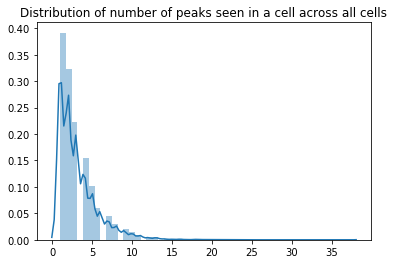

In [9]:
sns.distplot((peaks_dense>0).sum(axis=0))
plt.title("Distribution of number of peaks seen in a cell across all cells")

Text(0.5, 1.0, 'Distribution of the number of cells seen in a peak across all peaks')

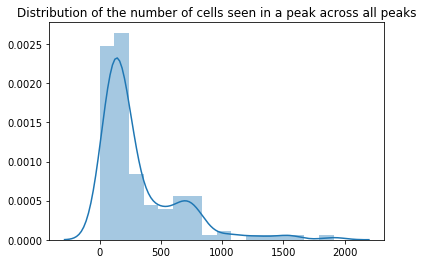

In [10]:
sns.distplot((peaks_dense>0).sum(axis=1))
plt.title("Distribution of the number of cells seen in a peak across all peaks")

In [11]:
#imm_anno = peak_annotations[peak_annotations["gene"].isin(immune_genes)].copy()
#imm_inds = peak_annotations.index
imm_anno["ID"] = imm_anno.apply(lambda x: x["gene"]+"_"+x["peak_type"]+"_"+x["distance"],axis=1)
imm_peaks_dense = peaks_dense.loc[imm_anno.index].copy()
#imm_peaks_dense = imm_peaks_dense.rename(imm_anno.set_index("Peak").apply(lambda x: x["gene"]+"_"+x["peak_type"],axis=1), axis=0)
#imm_peaks_dense

## Cluster based on IM genes 

### a. Dont cluster the immune peaks

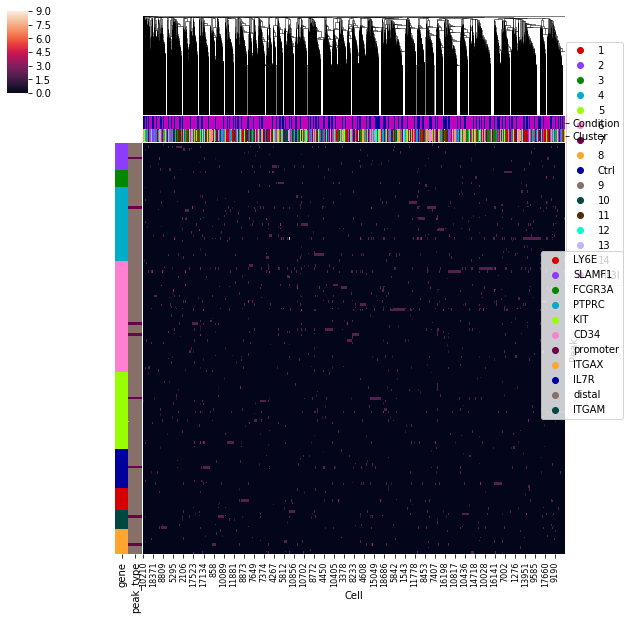

In [12]:
#rand_df = imm_peaks_dense.sample(n=500,axis=1)
ch.plot_cluster(imm_peaks_dense.fillna(0), row_meta=imm_anno[["gene", "peak_type"]], 
                col_meta=samples.drop("Barcode",axis=1), to_row_clust=False, row_names=False,
                metric='jaccard', to_legend=True, white_name=None )

### b. Clustering the immune peaks as well
and binarizing the results as 0 or >0

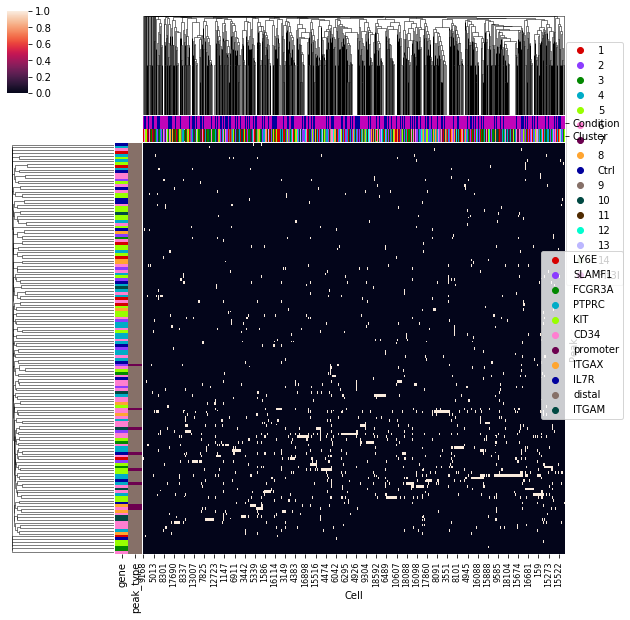

In [13]:

#geneType_imm_anno = imm_anno.rename(imm_anno.apply(lambda x: x["gene"]+"_"+x["peak_type"],axis=1), axis=0)
rand_df = imm_peaks_dense.sample(n=1000,axis=1)
ch.plot_cluster(rand_df.fillna(0), row_meta=imm_anno[["gene", "peak_type"]], 
                col_meta=samples.drop("Barcode",axis=1).loc[rand_df.columns], to_row_clust=True, 
                metric='jaccard', vmax=1, to_legend=True, white_name=None, row_names=False )

## Countplots for each gene and peak type

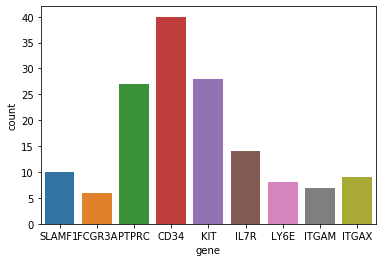

In [14]:
sns.countplot(imm_anno["gene"])

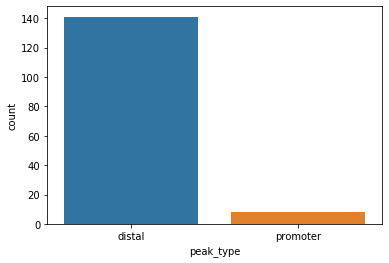

In [15]:
sns.countplot(imm_anno["peak_type"])